## MargFormer - Experiment2 - Star-Galaxy Classification

## Star-Galaxy Classification (Experiment 2) using Vision Transformer (ViT, Linformer) Model with CLS token derived uisng the Photometric Features. Query is defined using only photometry data in the Cross-Attention.

#### Import libraries

In [42]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from linformer import LinformerCA, Linformer
from vit_pytorch.efficient_new import ViT


#### 1. Load and extract the dataset

In [13]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment2/X_exp2.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/dnnx_exp2.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/objlist_exp2.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/y_exp2.npy", allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)




['GALAXY' 'STAR']


In [14]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)




The shape of the Train data is: (79996, 5, 32, 32)
The shape of the Validation data is: (10000, 5, 32, 32)
The shape of the Test data is: (10000, 5, 32, 32)


In [15]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)


##### Create dataset and dataloader for pytorch training

In [16]:
class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# Define your data augmentation transformations
image_transform = transforms.Compose([    
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create DataLoader for training and validation data
train_dataset = SGData(dnnx_train, X_train, y_train, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
val_dataset = SGData(dnnx_val, X_val, y_val, transform=image_transform)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_dataset = SGData(dnnx_test, X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)


#### 2. Initialize or Define the Model

In [17]:
# Initialize the PyTorch model
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_train.shape[1]

PATCH_SIZE = 4
DEPTH = 12
HIDDEN_DIM = 64
K_DIM = 64
NUM_HEADS = 8

LR = 1e-3
STEP_SIZE = 5
GAMMA = 0.9

LIN_DROPOUT = 0.1

seq_len = int((32/PATCH_SIZE)**2) + 1

## Linformer
lin = LinformerCA(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = ViT(image_size=32, patch_size=PATCH_SIZE, num_classes=n_classes, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=in_channels).to(device)


cuda:0


#### 3. Training the model



Epoch [1/300] - Train Loss: 0.5634, Train Accuracy: 0.6809, Validation Loss: 0.2750, Validation Accuracy: 0.8955
Epoch [2/300] - Train Loss: 0.2299, Train Accuracy: 0.9121, Validation Loss: 0.1754, Validation Accuracy: 0.9407
Epoch [3/300] - Train Loss: 0.1835, Train Accuracy: 0.9345, Validation Loss: 0.1579, Validation Accuracy: 0.9465
Epoch [4/300] - Train Loss: 0.1692, Train Accuracy: 0.9409, Validation Loss: 0.1531, Validation Accuracy: 0.9486
Epoch [5/300] - Train Loss: 0.1637, Train Accuracy: 0.9423, Validation Loss: 0.1765, Validation Accuracy: 0.9385
Epoch [6/300] - Train Loss: 0.1569, Train Accuracy: 0.9445, Validation Loss: 0.1448, Validation Accuracy: 0.9505
Epoch [7/300] - Train Loss: 0.1524, Train Accuracy: 0.9464, Validation Loss: 0.1416, Validation Accuracy: 0.9503
Epoch [8/300] - Train Loss: 0.1492, Train Accuracy: 0.9476, Validation Loss: 0.1373, Validation Accuracy: 0.9516
Epoch [9/300] - Train Loss: 0.1455, Train Accuracy: 0.9480, Validation Loss: 0.1280, Validatio

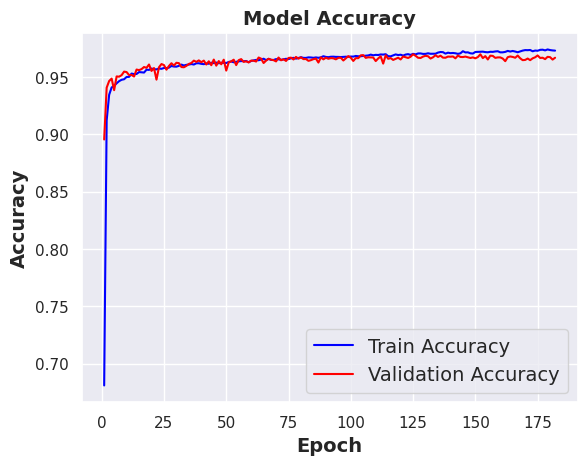

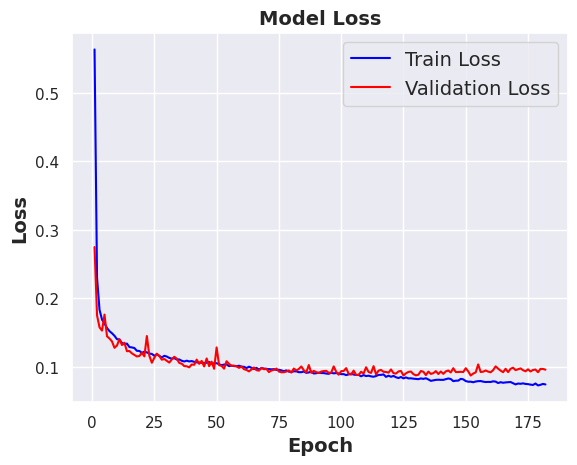

In [18]:
train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
best_model_state = None  # Initialize a variable to store the best model state
counter = 0

# Training loop
epochs = 300
epoch1 =0
print('\n')
for epoch in range(epochs):
    epoch1+=1
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_x1, batch_x2, batch_y in train_loader:
        batch_x1 = batch_x1.to(device)
        batch_x2 = batch_x2.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x1, batch_x2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)
    
    model.eval()
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x1, batch_x2, batch_y in val_loader:
            batch_x1 = batch_x1.to(device)
            batch_x2 = batch_x2.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x1, batch_x2)
            val_loss += criterion(output, batch_y).item()
            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)
    
    model.train()
        
    #Check for early stopping and save best model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # Store the current best model state
        torch.save(best_model_state, "Trained_Models/Experiment2/SG/EX2_SG_MargFormer_Model.pth")
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        if best_model_state is not None:
            model.load_state_dict(best_model_state)  # Restore best model state
        counter = 0  # Reset the counter    
        break

    print(f'Epoch [{epoch+1}/{epochs}] - '
      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Create the range of epochs
epoch_range = range(1, epoch1+1)

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Model Accuracy', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_Accuracy.png")
# Show the plot
plt.show()
plt.close()

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_loss_arr, label='Train Loss', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_loss_arr, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.title('Model Loss', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_Loss.png")
# Show the plot
plt.show()
plt.close()


#### 4. Testing the Model



Identified 9688 correct labels out of 10000 labels
Accuracy: 0.9688
Precision: 0.9688737765668289
Recall: 0.9687927550615674
F1 Score: 0.9687983825081492
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[4808  186]
 [ 126 4880]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      4994
           1       0.96      0.97      0.97      5006

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

(array([   0,    1,    2, ..., 9997, 9998, 9999]), 0.9688, 0.9688737765668289, 0.9687927550615674, array([[4808,  186],
       [ 126, 4880]]), '              precision    recall  f1-score   support\n\n           0       0.97      0.96      0.97      4994\n           1       0.96      0.97      0.97      5006\n\n    accuracy                           0.97     10000\n   macro avg       0.97      0.97      0.97     1

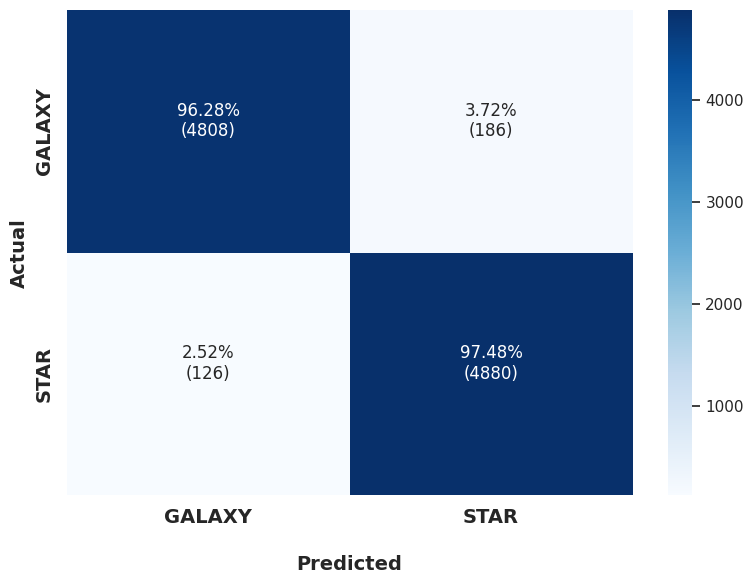

In [19]:
torch.cuda.empty_cache()

# Set the model to evaluation mode
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)
model.load_state_dict(torch.load('./Trained_Models/Experiment2/SG/EX2_SG_MargFormer_Model.pth', map_location=device))
model.eval()
y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for pf, images, labels in test_loader:
        pf = pf.to(device)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(pf, images)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_CM.png")
plt.show()
plt.close()


## Result Analysis

In [20]:
del(dnnx_train, dnnx_val, dnnx_test, X_train, X_val, X_test)

In [21]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment2/X_exp2.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/dnnx_exp2.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/objlist_exp2.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment2/y_exp2.npy", allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)

zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)


class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# Create DataLoader for training and validation data
train_dataset = SGData(dnnx_train, X_train, y_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=8)
val_dataset = SGData(dnnx_val, X_val, y_val, transform=None)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_dataset = SGData(dnnx_test, X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)




['GALAXY' 'STAR']


The shape of the Train data is: (79996, 5, 32, 32)
The shape of the Validation data is: (10000, 5, 32, 32)
The shape of the Test data is: (10000, 5, 32, 32)


In [24]:
def get_preds(loader):
    model.eval()
    all_logits = []

    with torch.no_grad():
        for pf, images, labels in loader:
            pf = pf.to(device)
            images = images.to(device)
            logits = model(pf, images)      # [batch, 3]
            all_logits.append(logits.cpu())

    all_logits = torch.cat(all_logits, dim=0)   # [N, 3]
    all_probs  = F.softmax(all_logits, dim=1)   # probabilities, rows sum to 1
    all_probs  = all_probs.numpy()

    pred_labels = all_probs.argmax(axis=1)
    return all_probs, pred_labels

preds_train, y_train_pred = get_preds(train_loader)
print(get_metrics(y_train_pred, y_train, label_strings))
print('\n')

preds_val, y_val_pred = get_preds(val_loader)
print(get_metrics(y_val_pred, y_val, label_strings))
print('\n')

preds_test, y_test_pred = get_preds(test_loader)
print(get_metrics(y_test_pred, y_test, label_strings))


Identified 78176 correct labels out of 79996 labels
Accuracy: 0.9772488624431221
Precision: 0.9773272967431617
Recall: 0.9772400049545058
F1 Score: 0.9772475739439298
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[38787  1153]
 [  667 39389]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98     39940
           1       0.97      0.98      0.98     40056

    accuracy                           0.98     79996
   macro avg       0.98      0.98      0.98     79996
weighted avg       0.98      0.98      0.98     79996

(array([    0,     1,     2, ..., 79993, 79994, 79995]), 0.9772488624431221, 0.9773272967431617, 0.9772400049545058, array([[38787,  1153],
       [  667, 39389]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.98     39940\n           1       0.97      0.98      0.98     40056\n\n    accuracy                           0.98     79996\n   macro avg

In [25]:
df = pd.read_csv("/scratch/srinadb/Foundation/Dataset/Experiment2/photofeatures_exp2.csv",index_col=0)
df = df[df["class"]!="QSO"].reset_index()
df = df.set_index(["objid"])

df.loc[objlist_train, ["set"]] = "TRAIN"
df.loc[objlist_val, ["set"]] = "VALIDATION"
df.loc[objlist_test, ["set"]] = "TEST"

df.loc[objlist_train, ["pred_class"]] = label_strings[preds_train.argmax(axis=1)]
df.loc[objlist_val, ["pred_class"]] = label_strings[preds_val.argmax(axis=1)]
df.loc[objlist_test, ["pred_class"]] = label_strings[preds_test.argmax(axis=1)]

pgal_train = preds_train[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_train = preds_train[:,np.where(label_strings=="STAR")[0][0]]

pgal_val = preds_val[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_val = preds_val[:,np.where(label_strings=="STAR")[0][0]]

pgal_test = preds_test[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_test = preds_test[:,np.where(label_strings=="STAR")[0][0]]


df.to_csv("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_results.csv")


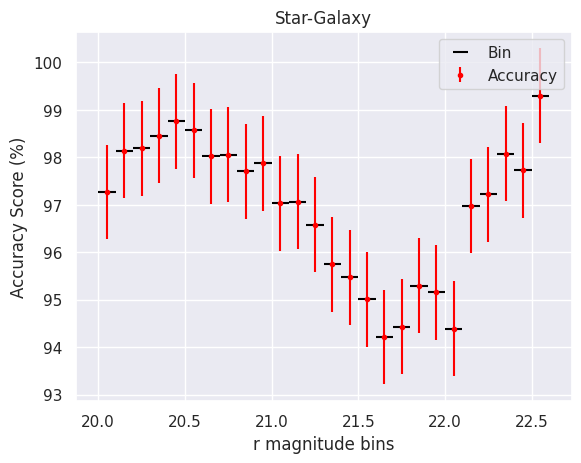

In [26]:
sns.set_palette("tab10")

df = pd.read_csv("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_results.csv")

subdflist = []

bin_size = 0.1
lower_bin_list = np.arange(20,23,bin_size)
bad_lower_bin=[]
acclist = []
f1list = []
reportlist = []
num_samplelist = []
starmaglist = []
galmaglist = []

for lower_bin in lower_bin_list:
#     print(f"******************** {lower_bin} < r <= {lower_bin+bin_size} ********************")
    subdf = df[(
        ((df["dered_r"]+df["extinction_r"]) > lower_bin) & 
        ((df["dered_r"]+df["extinction_r"]) <= lower_bin+bin_size)
    )]
    # Choose equal number of stars and galaxies
    min_num = subdf["class"].value_counts().min()
    if min_num < 50:
        bad_lower_bin.append(lower_bin)
        continue
    s1 = subdf[subdf["class"]=="GALAXY"].sample(n=min_num)
    galmaglist.append((s1["dered_r"]+s1["extinction_r"]).to_numpy())
    s2 = subdf[subdf["class"]=="STAR"].sample(n=min_num)
    starmaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    num_samplelist.append(min_num)
    subdf = pd.concat([s1,s2])
    subdflist.append(subdf)
    
    accuracy = metrics.accuracy_score(subdf["class"], subdf["pred_class"])
    f1score = metrics.f1_score(subdf["class"], subdf["pred_class"],average='macro')
    report = metrics.classification_report(subdf["class"], subdf["pred_class"],output_dict=True)
    reportlist.append(report)
    acclist.append(accuracy)
    f1list.append(f1score)

bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

galmaglist = np.concatenate(galmaglist)

starmaglist = np.concatenate(starmaglist)

plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, xerr=bin_size/2, fmt=" ",color="black",label="Bin")
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, yerr=0.01*100,fmt=".",color="red",label="Accuracy")
# plt.errorbar(lower_bin_list+bin_size/2, f1list, yerr=0.01,label="F1 Score")
plt.legend()
plt.title("Star-Galaxy")
plt.xlabel("r magnitude bins")
plt.ylabel("Accuracy Score (%)")
# plt.ylim(93, 100)
plt.savefig("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_v2.pdf")


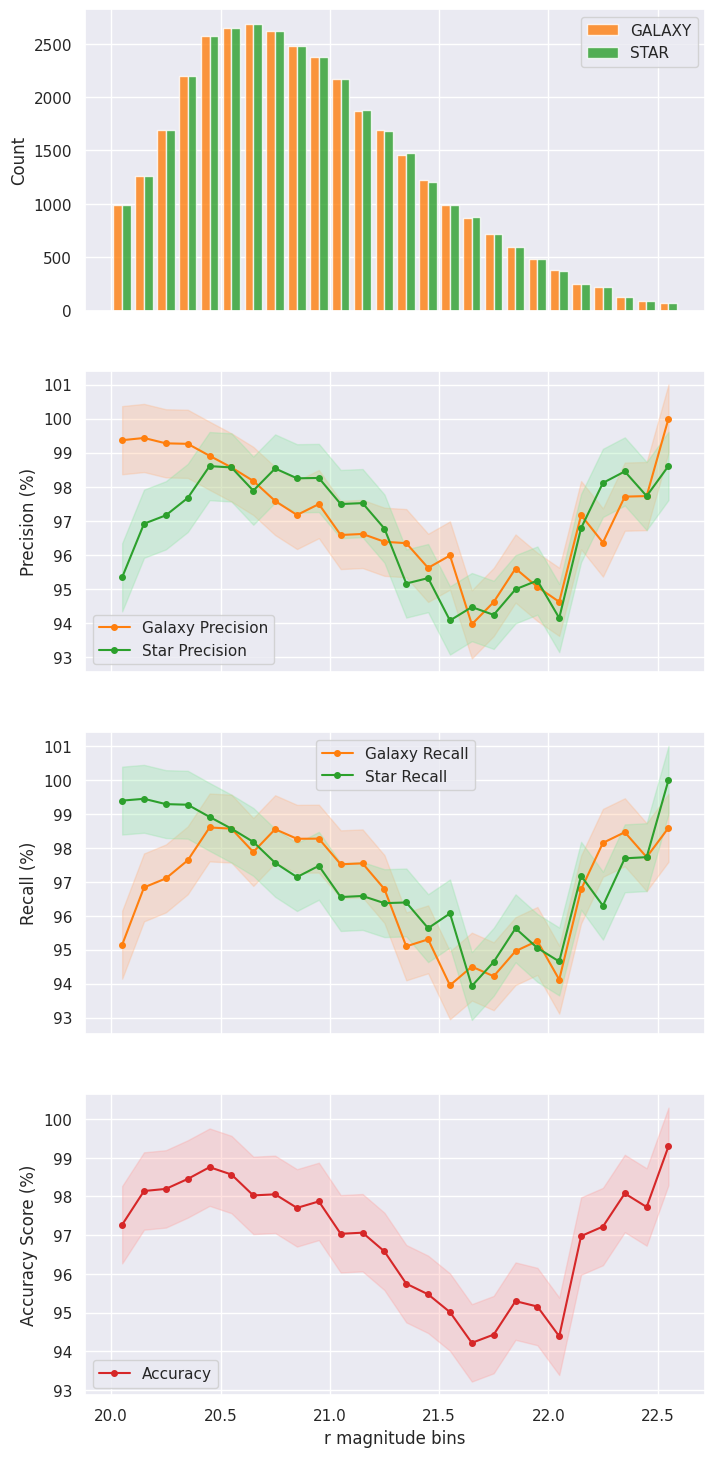

In [27]:
subdfs = pd.concat(subdflist)
subdfs["r"]=subdfs["dered_r"]+subdfs["extinction_r"]

gal_recall_list = []
gal_precision_list = []
star_recall_list = []
star_precision_list = []
for r in reportlist:
    gal_recall_list.append(r["GALAXY"]["recall"])
    gal_precision_list.append(r["GALAXY"]["precision"])
    star_recall_list.append(r["STAR"]["recall"])
    star_precision_list.append(r["STAR"]["precision"])
    
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,sharex=True, figsize=(8,18))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2


d1 = subdfs[subdfs["class"]=="GALAXY"]["r"]
d2 = subdfs[subdfs["class"]=="STAR"]["r"]

ax1.hist([d1, d2], color=[galcolor,starcolor],
         alpha=0.8, label=["GALAXY","STAR"],bins=len(lower_bin_list))
ax1.set_ylabel("Count")

ax1.legend()


y_ax1 = np.array(gal_precision_list)
y_ax2 = np.array(star_precision_list)

ax2.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Precision",color=galcolor)
ax2.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax2.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Precision",color=starcolor)
ax2.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
                 color=sns.color_palette("pastel")[2], alpha=0.3)
ax2.set_ylabel("Precision (%)")
ax2.legend()



y_ax1 = np.array(gal_recall_list)
y_ax2 = np.array(star_recall_list)

ax3.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Recall",color=galcolor)
ax3.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax3.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Recall",color=starcolor)
ax3.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
             color=sns.color_palette("pastel")[2], alpha=0.3)
ax3.set_ylabel("Recall (%)")
ax3.legend()



y_ax1 = np.array(acclist)
y_ax2 = np.array(f1list)
ax4.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Accuracy",color=acccolor)
# ax4.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="F1 Score",color=f1color)
ax4.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[3], alpha=0.3)
ax4.set_ylabel("Accuracy Score (%)")
ax4.legend()

plt.xlabel("r magnitude bins")


# plt.suptitle("Star-Galaxy")
plt.savefig("Trained_Models/Experiment2/SG/EX2_SG_v2Set.pdf")
plt.show()    


In [28]:
# True labels as strings
label_strings_list = [str(x) for x in label_strings]
true_labels_str = [label_strings_list[i] for i in y_test]

# Predicted labels (argmax) as strings
pred_idx = preds_test.argmax(axis=1)
pred_labels_str = [label_strings_list[i] for i in pred_idx]

# Build DataFrame
data = {}

# String labels instead of 0/1
data["true_label"] = true_labels_str
# data["pred_label"] = pred_labels_str  # optional but useful

# Probability columns with class names instead of 0,1,...
for i, name in enumerate(label_strings_list):
    # if you prefer lowercase column names, use name.lower() here
    col_name = f"{name}"
    data[col_name] = preds_test[:, i]

df = pd.DataFrame(data)
d_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

n = len(d_shuffled)
split_idx = n // 2   # if n is odd, one part will have 1 extra row

# Split into calibration and test
calibration_data = d_shuffled.iloc[:split_idx].copy()
test_data  = d_shuffled.iloc[split_idx:].copy()

# Save to CSV
# df.to_csv("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_test_predictions.csv", index=False)
# print("Saved to test_predictions_with_names.csv")


CP mode:          mondrian
Example alpha:    0.32
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.32:
  GALAXY: 0.002610
  STAR: 0.004076
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.32:
  Set size 0: 1639 / 5000 (32.78% of test points)
  Set size 1: 3361 / 5000 (67.22% of test points)

Examples with prediction set size = 0:
  Test index 5002: true_label=GALAXY, argmax_pred=STAR, pred_set=[]
  Test index 5005: true_label=STAR, argmax_pred=STAR, pred_set=[]

Examples with prediction set size = 1:
  Test index 5000: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 5001: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
------------------------------------------------------------
Generating coverage plot...


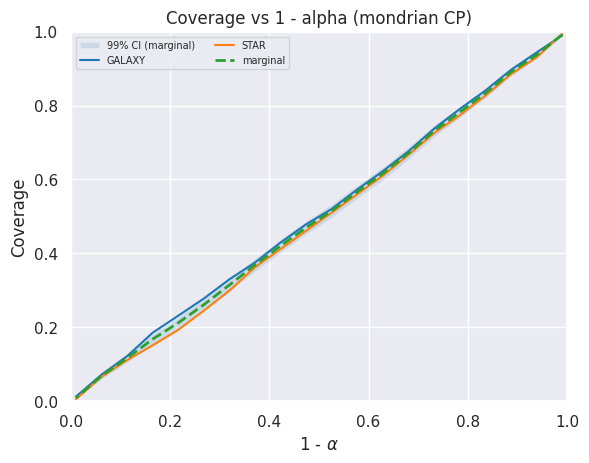

Generating set-size plot...


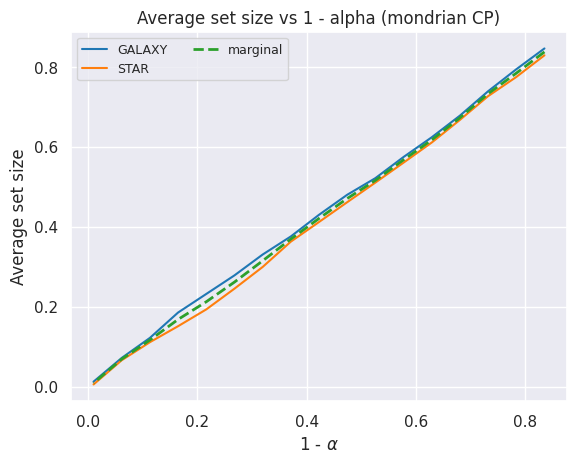

Generating ROC-style plot...


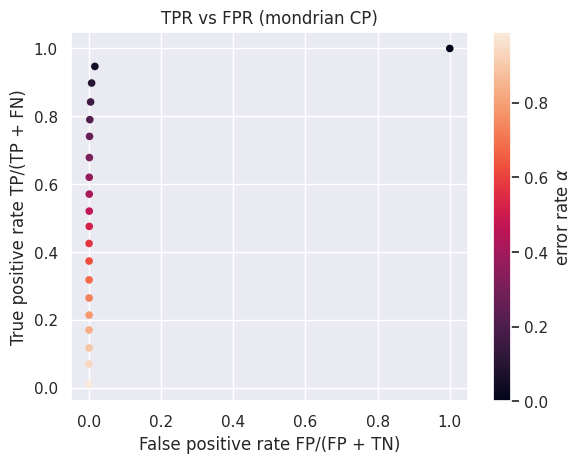

{'coverage_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_68/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_68/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_68/roc_mondrian.png'}

In [29]:
from conformal_cp import ConformalCPAnalysis

analyzer = ConformalCPAnalysis(cp_mode="mondrian", nonconf_type="baseline")
analyzer.fit(calibration_data, test_data)

# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.32,
    cutoff=3,
    save_dir="Trained_Models/Experiment2/SG/MargFormer/cp_plots_68",
    show_plots=True,
)



In [31]:
print(test_data.loc[5000])
print('\n')
print(test_data.loc[5001])
print('\n')
print(test_data.loc[5002])
print('\n')
print(test_data.loc[5005])


true_label        STAR
GALAXY        0.000145
STAR          0.999854
Name: 5000, dtype: object


true_label      GALAXY
GALAXY        0.999669
STAR          0.000331
Name: 5001, dtype: object


true_label      GALAXY
GALAXY        0.383137
STAR          0.616863
Name: 5002, dtype: object


true_label        STAR
GALAXY        0.004235
STAR          0.995765
Name: 5005, dtype: object


CP mode:          mondrian
Example alpha:    0.1
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.1:
  GALAXY: 0.077251
  STAR: 0.043166
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.1:
  Set size 0: 452 / 5000 (9.04% of test points)
  Set size 1: 4548 / 5000 (90.96% of test points)

Examples with prediction set size = 0:
  Test index 5002: true_label=GALAXY, argmax_pred=STAR, pred_set=[]
  Test index 5071: true_label=GALAXY, argmax_pred=GALAXY, pred_set=[]

Examples with prediction set size = 1:
  Test index 5000: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 5001: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
------------------------------------------------------------
Generating coverage plot...


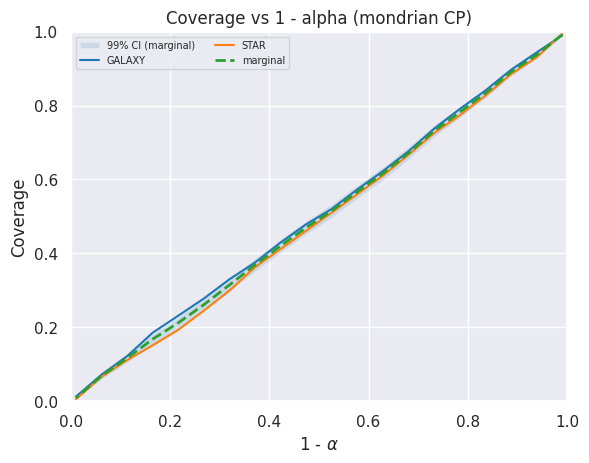

Generating set-size plot...


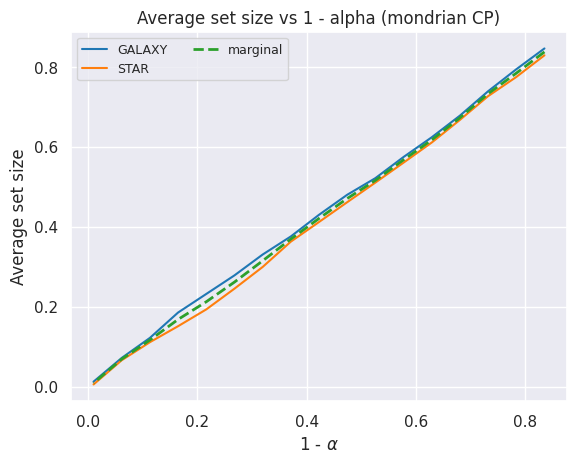

Generating ROC-style plot...


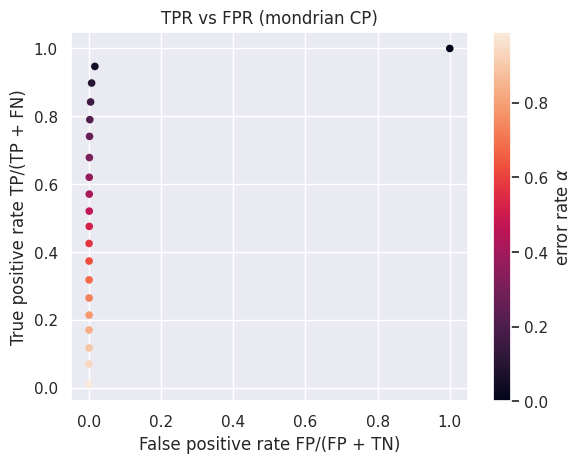

{'coverage_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_90/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_90/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_90/roc_mondrian.png'}

In [32]:

# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.1,
    cutoff=3,
    save_dir="Trained_Models/Experiment2/SG/MargFormer/cp_plots_90",
    show_plots=True,
)


In [33]:
print(test_data.loc[5000])
print('\n')
print(test_data.loc[5001])
print('\n')
print(test_data.loc[5002])
print('\n')
print(test_data.loc[5071])


true_label        STAR
GALAXY        0.000145
STAR          0.999854
Name: 5000, dtype: object


true_label      GALAXY
GALAXY        0.999669
STAR          0.000331
Name: 5001, dtype: object


true_label      GALAXY
GALAXY        0.383137
STAR          0.616863
Name: 5002, dtype: object


true_label      GALAXY
GALAXY        0.875453
STAR          0.124547
Name: 5071, dtype: object


CP mode:          mondrian
Example alpha:    0.05
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.05:
  GALAXY: 0.309270
  STAR: 0.165458
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.05:
  Set size 0: 162 / 5000 (3.24% of test points)
  Set size 1: 4838 / 5000 (96.76% of test points)

Examples with prediction set size = 0:
  Test index 5002: true_label=GALAXY, argmax_pred=STAR, pred_set=[]
  Test index 5094: true_label=GALAXY, argmax_pred=GALAXY, pred_set=[]

Examples with prediction set size = 1:
  Test index 5000: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 5001: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
------------------------------------------------------------
Generating coverage plot...


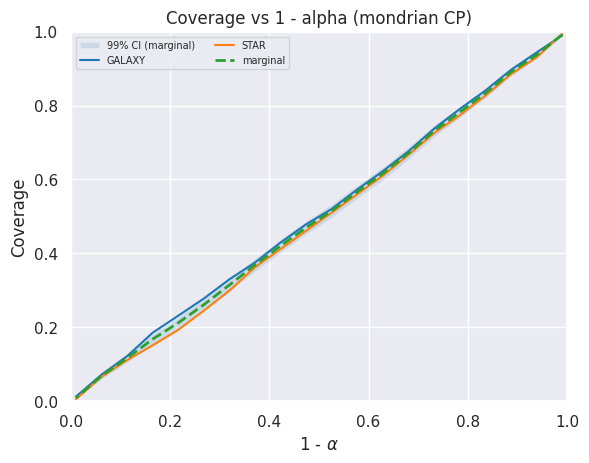

Generating set-size plot...


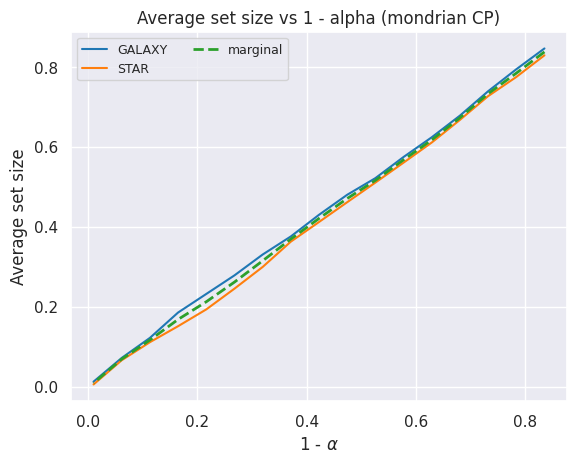

Generating ROC-style plot...


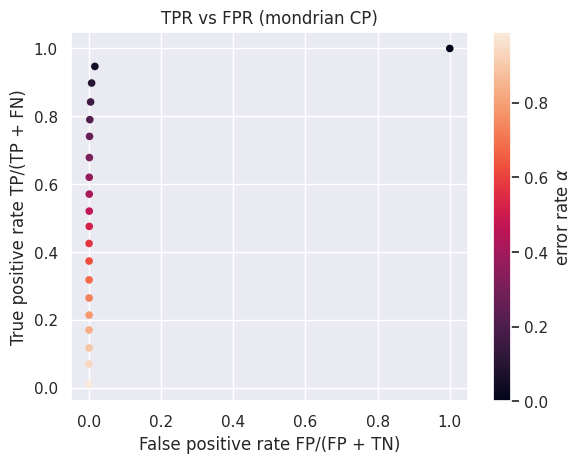

{'coverage_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_95/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_95/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_95/roc_mondrian.png'}

In [34]:
# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.05,
    cutoff=3,
    save_dir="Trained_Models/Experiment2/SG/MargFormer/cp_plots_95",
    show_plots=True,
)


In [35]:
print(test_data.loc[5000])
print('\n')
print(test_data.loc[5001])
print('\n')
print(test_data.loc[5002])
print('\n')
print(test_data.loc[5094])


true_label        STAR
GALAXY        0.000145
STAR          0.999854
Name: 5000, dtype: object


true_label      GALAXY
GALAXY        0.999669
STAR          0.000331
Name: 5001, dtype: object


true_label      GALAXY
GALAXY        0.383137
STAR          0.616863
Name: 5002, dtype: object


true_label      GALAXY
GALAXY        0.678816
STAR          0.321184
Name: 5094, dtype: object


CP mode:          mondrian
Example alpha:    0.01
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.01:
  GALAXY: 0.938492
  STAR: 0.895774
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.01:
  Set size 1: 4624 / 5000 (92.48% of test points)
  Set size 2: 376 / 5000 (7.52% of test points)

Examples with prediction set size = 1:
  Test index 5000: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 5001: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']

Examples with prediction set size = 2:
  Test index 5002: true_label=GALAXY, argmax_pred=STAR, pred_set=['GALAXY', 'STAR']
  Test index 5071: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY', 'STAR']
------------------------------------------------------------
Generating coverage plot...


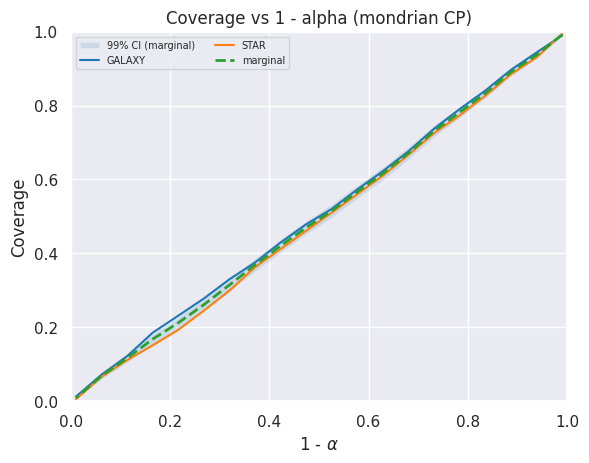

Generating set-size plot...


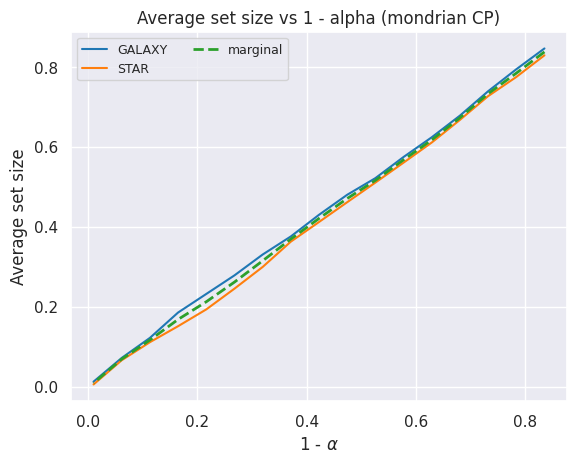

Generating ROC-style plot...


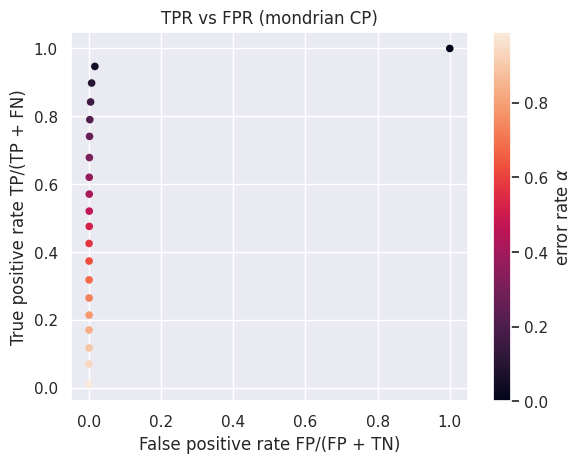

{'coverage_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_99/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_99/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment2/SG/MargFormer/cp_plots_99/roc_mondrian.png'}

In [36]:
# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.01,
    cutoff=3,
    save_dir="Trained_Models/Experiment2/SG/MargFormer/cp_plots_99",
    show_plots=True,
)


In [37]:
print(test_data.loc[5000])
print('\n')
print(test_data.loc[5001])
print('\n')
print(test_data.loc[5002])
print('\n')
print(test_data.loc[5071])


true_label        STAR
GALAXY        0.000145
STAR          0.999854
Name: 5000, dtype: object


true_label      GALAXY
GALAXY        0.999669
STAR          0.000331
Name: 5001, dtype: object


true_label      GALAXY
GALAXY        0.383137
STAR          0.616863
Name: 5002, dtype: object


true_label      GALAXY
GALAXY        0.875453
STAR          0.124547
Name: 5071, dtype: object


In [43]:
df = pd.read_csv("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_results.csv")
sns.set_palette("tab10")

def plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha: float = 0.1,
    r_min: float = 20.0,
    r_max: float = 23.0,
    bin_size: float = 0.1,
    min_per_bin: int = 50,
    save_path: str = None,
    show: bool = True,
):
    """
    Plot conformal coverage (y) vs r-magnitude (x) for a fixed alpha.

    Parameters
    ----------
    analyzer : ConformalCPAnalysis
        Fitted analyzer (after .fit()).
    r_mag_test : array-like, shape (n_samples,)
        r-magnitudes for the test set in the same order as analyzer.test_data.
    alpha : float
        Miscoverage level used in CP (e.g. 0.1 -> target coverage 0.9).
    r_min, r_max : float
        Range of r-magnitudes to consider.
    bin_size : float
        Bin width in magnitudes.
    min_per_bin : int
        Skip bins with fewer than this many examples.
    save_path : str or None
        If not None, save the plot to this path.
    show : bool
        If True, call plt.show(). If False, just return fig, ax.
    """
    # --- sanity ---
    r_mag_test = np.asarray(r_mag_test)
    if len(r_mag_test) != len(analyzer.test_data):
        raise ValueError("r_mag_test must have the same length as analyzer.test_data")

    # --- calibrate CP at this alpha ---
    qhat_dict = analyzer._calibrate(analyzer.calibration_data, alpha=alpha)

    # --- compute per-example coverage indicator ---
    covered = np.zeros(len(analyzer.test_data), dtype=bool)
    for i, (_, row) in enumerate(analyzer.test_data.iterrows()):
        pred_set = analyzer._predict_set(row, qhat_dict)
        covered[i] = (row["true_label"] in pred_set)

    # --- bin in r magnitude ---
    lower_bins = np.arange(r_min, r_max, bin_size)
    centers = lower_bins + bin_size / 2

    covs = []
    n_points = []
    ci_low = []
    ci_high = []

    for lb in lower_bins:
        mask = (r_mag_test > lb) & (r_mag_test <= lb + bin_size)
        n_bin = mask.sum()
        n_points.append(n_bin)

        if n_bin < min_per_bin:
            covs.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        n_cov = covered[mask].sum()
        cov = n_cov / n_bin

        # binomial confidence interval for coverage
        low, high = proportion_confint(n_cov, n_bin, alpha=0.05, method="beta")

        covs.append(cov)
        ci_low.append(low)
        ci_high.append(high)

    covs = np.array(covs)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    # --- plot ---
    fig, ax = plt.subplots()

    # Only plot bins with enough points
    valid = ~np.isnan(covs)
    x = centers[valid]
    y = covs[valid]
    yerr_lower = y - ci_low[valid]
    yerr_upper = ci_high[valid] - y

    ax.errorbar(
        x,
        y,
        xerr=bin_size / 2,
        yerr=[yerr_lower, yerr_upper],
        fmt="o",
        capsize=2,
        label="Empirical coverage",
    )

    # expected coverage line
    ax.axhline(1 - alpha, linestyle="--", label=fr"Target $1-\alpha={1-alpha:.2f}$")

    ax.set_xlabel("r magnitude")
    ax.set_ylabel("Coverage")
    ax.set_ylim(0, 1.05)
    ax.set_title(f"Conformal coverage vs r magnitude (α={alpha:.2f}, {analyzer.cp_mode} CP)")
    ax.grid(True)
    ax.legend()

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax, {
        "bin_centers": centers,
        "coverage": covs,
        "n_points": np.array(n_points),
        "ci_low": ci_low,
        "ci_high": ci_high,
    }


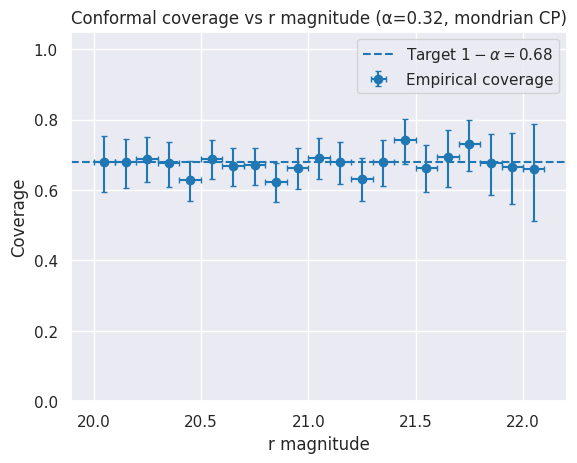

In [44]:
# Build r magnitude array for the test set
r_mag_test = (df.loc[test_data.index, "dered_r"] + 
              df.loc[test_data.index, "extinction_r"]).to_numpy()

# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.32,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment2/SG/MargFormer/cp_plots_68/coverage_vs_rmag.png",
    show=True,
)


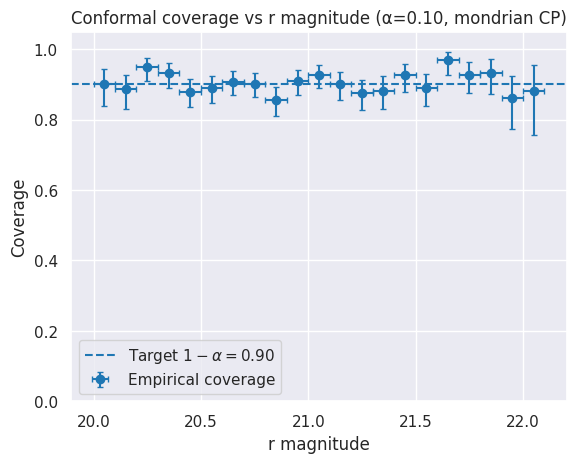

In [45]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.1,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment2/SG/MargFormer/cp_plots_90/coverage_vs_rmag.png",
    show=True,
)


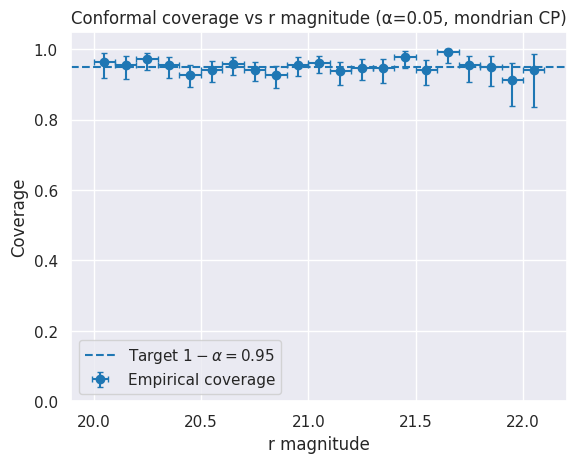

In [46]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.05,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment2/SG/MargFormer/cp_plots_95/coverage_vs_rmag.png",
    show=True,
)


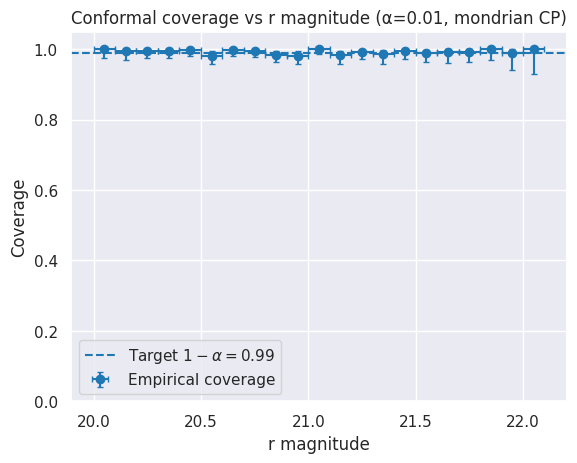

In [47]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.01,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment2/SG/MargFormer/cp_plots_99/coverage_vs_rmag.png",
    show=True,
)
